# Interactive Genetic Programming visualizer

*TODOs:*
- save/load populations

In [ ]:
#@title Imports { run: "auto", display-mode: "form" }
import numpy as np
import torch as th
from typing import Any, Dict, List, Optional, Tuple
from tqdm.notebook import tnrange
import matplotlib.pyplot as plt
from google.colab import files
from datetime import datetime

In [ ]:
#@title Configurations and Hyper Parameters { run: "auto" }
#@markdown Note that functions and terminals set are predefined in the code.

#@markdown * Population properties:
max_depth = 8 #@param {type:"slider", min:1, max:10, step:1}
population_size = 50 #@param {type:"slider", min:10, max:100, step:10}
max_len = 300 #@param {type:"slider", min:50, max:500, step:10}

#@markdown * Evolutionary hyper parameters
mutation_probability = 0.4 #@param {type:"slider", min:0.01, max:1, step:0.05}
switch_probability = 0.1 #@param {type:"slider", min:0.01, max:1, step:0.05}

#@markdown * Insert the name of an existing population file here if you wish to load it.
pop_name = "" #@param {type:"string"}

function_set = {
    'sum': {'function': lambda x, y : x + y,
            'arity': 2},
    'sub': {'function': lambda x, y : x - y,
                 'arity': 2},
    'mul': {'function': lambda x, y : x * y,
             'arity': 2},
    'div': {'function': lambda x, y : x / (y + 1e-6),
            'arity': 2},
    'sin': {'function': lambda x: th.sin(x),
            'arity': 1},
    'cos': {'function': lambda x: th.cos(x),
            'arity': 1},
    'tan': {'function': lambda x: th.tan(x),
            'arity': 1},
    'square': {'function': lambda x: x ** 2,
               'arity': 1},
    'cube': {'function': lambda x: x ** 3,
             'arity': 1},
    'id': {'function': lambda x: x,
           'arity': 1},
    'sign': {'function': lambda x: -x,
             'arity': 1},
}

terminal_set = ['x', 'y', np.pi, np.e, 2, .5]

In [ ]:
#@title Genetic Programming class


class GP:
    def __init__(self,
                 function_set: Dict[str, Dict[str, Any]],
                 terminal_set: List[Any]):
        self.function_set = function_set
        self.terminal_set = terminal_set
        self.population = []

        self.initialize_population()
        
    def initialize_population(self):
        self.population = []
        for _ in tnrange(population_size, desc='Generating population...'):
            tree = self._generate_tree(0)
            self.population.append(tree)
    
    def _generate_tree(self,
                       depth):
        if th.rand(1,) < 0.9 and depth < max_depth:
            fname = list(self.function_set.keys())[np.random.choice(len(self.function_set))]
            children = [self._generate_tree(depth + 1) for _ in range(self.function_set[fname]['arity'])]
            return {'function': fname, 'children': children}
        else:
            terminal = self.terminal_set[np.random.choice(len(self.terminal_set))]
            return {'terminal': terminal}
    
    def evaluate_tree(self,
                      tree: Dict[str, Any],
                      x: th.Tensor,
                      y: th.Tensor):
        if 'function' in tree:
            func = self.function_set[tree['function']]['function']
            children = tree['children']
            args = [self.evaluate_tree(child, x, y) for child in children]
            return func(*args)
        elif 'terminal' in tree:
            terminal = tree['terminal']
            if terminal == 'x':
                return x
            elif terminal == 'y':
                return y
            else:
                return th.ones_like(x) * terminal
        else:
            raise NotImplementedError(f'Unrecognized node: {tree}')
    
    def generate_image(self,
                       tree: Dict[str, Any],
                       image_size: Tuple[int, int]) -> th.Tensor:
        image = th.ones((*image_size, 3))
        # vectorized powah
        xs, ys = th.arange(image_size[0]), th.arange(image_size[1])
        x, y = th.meshgrid(xs, ys, indexing='ij')
        in_x, in_y = th.zeros_like(image), th.zeros_like(image)
        in_x[:,:,0] = (x / image_size[0]) * 2 - 1
        in_y[:,:,0] = (y / image_size[1]) * 2 - 1
        if channel_mode == 'identity':
            in_x[:,:,1] = in_x[:,:,0]
            in_y[:,:,1] = in_y[:,:,0]
            in_x[:,:,2] = in_x[:,:,0]
            in_y[:,:,2] = in_y[:,:,0]
        elif channel_mode == 'divide':
            in_x[:,:,1] = ((x / 2) / image_size[0]) * 2 - 1
            in_y[:,:,1] = ((y / 2) / image_size[1]) * 2 - 1
            in_x[:,:,2] = ((x / 3) / image_size[0]) * 2 - 1
            in_y[:,:,2] = ((y / 3) / image_size[1]) * 2 - 1
        elif channel_mode == 'multiply':
            in_x[:,:,1] = ((x * 2) / image_size[0]) * 2 - 1
            in_y[:,:,1] = ((y * 2) / image_size[1]) * 2 - 1
            in_x[:,:,2] = ((x * 3) / image_size[0]) * 2 - 1
            in_y[:,:,2] = ((y * 3) / image_size[1]) * 2 - 1
        elif channel_mode == 'power':
            in_x[:,:,1] = ((x ** 2) / image_size[0]) * 2 - 1
            in_y[:,:,1] = ((y ** 2) / image_size[1]) * 2 - 1
            in_x[:,:,2] = ((x ** 3) / image_size[0]) * 2 - 1
            in_y[:,:,2] = ((y ** 3) / image_size[1]) * 2 - 1
        in_x *= scale_x
        in_y *= scale_y
        in_x += offset_x
        in_y += offset_y
        return self.evaluate_tree(tree, in_x, in_y)        

    def _to_tensor(self,
                   tree: Dict[str, Any],
                   arr: th.Tensor,
                   idx: int = 0) -> int:
        if 'function' in tree:
            f_idx = list(self.function_set.keys()).index(tree['function'])
            arr[idx] = 0
            arr[idx + 1] = f_idx
            idx += 1
            for children in tree['children']:
                idx = self._to_tensor(children, arr, idx + 1)
            return idx
        elif 'terminal' in tree:
            t_idx = self.terminal_set.index(tree['terminal'])
            arr[idx] = 1
            arr[idx + 1] = t_idx
            return idx + 1
        else:
            raise NotImplementedError(f'Unrecognized node type: {list(tree.keys())[0]}')

    def to_tensor(self,
                  tree: Dict[str, Any]) -> th.Tensor:
        arr = -th.ones(max_len, dtype=th.int8)
        self._to_tensor(tree, arr, 0)
        return arr
    
    def __from_tensor(self,
                      arr: th.Tensor,
                      i: int = 0) -> Tuple[Optional[Dict[str,Any]], int]:
        if arr[i] == -1:
            return None, i
        if arr[i] == 0:
            fname = list(self.function_set.keys())[arr[i + 1]]
            children = []
            i += 2
            for _ in range(self.function_set[fname]['arity']):
                node, i = self.__from_tensor(arr=arr, i=i)
                if node is not None:
                    children.append(node)
                else:
                    break
            return {'function': fname, 'children': children}, i
        elif arr[i] == 1:
            terminal = self.terminal_set[arr[i + 1]]
            return {'terminal': terminal}, i + 2
        else:
            raise NotImplementedError(f'Unknown node value: {arr[i]} at {i}')
    
    def from_tensor(self,
                    arr: th.Tensor) -> Optional[Dict[str, Any]]:
        t, _ = self.__from_tensor(arr=arr,
                                  i=0)
        return t

    def mutate(self,
               tree,
               depth):
        r = th.rand(1)
        if 'function' in tree:
            if r < switch_probability:
                # switch node type
                terminal = self.terminal_set[np.random.choice(len(self.terminal_set))]
                tree = {'terminal': terminal}
            elif r < mutation_probability:
                # switch function type
                fname = list(self.function_set.keys())[np.random.choice(len(self.function_set))]
                arity = self.function_set[fname]['arity']
                tree['function'] = fname
                # adjust children according to new func arity
                if len(tree['children']) < arity:
                    tree['children'].extend([self._generate_tree(depth=depth + 1) for _ in range(arity - len(tree['children']))])
                else:
                    tree['children'] = tree['children'][:arity]
        elif 'terminal' in tree:
            if r < switch_probability:
                # switch node type
                fname = list(self.function_set.keys())[np.random.choice(len(self.function_set))]
                children = [self._generate_tree(depth + 1) for _ in range(self.function_set[fname]['arity'])]
                tree = {'function': fname, 'children': children}
            elif r < mutation_probability:
                # switch terminal value
                tree['terminal'] = self.terminal_set[np.random.choice(len(self.terminal_set))]
        for node in tree.get('children', []):
            node = self.mutate(node, depth + 1)
        return tree

    def save(self,
             fname):
        pass
    
    def load(self,
             fname):
        pass


gp = GP(function_set=function_set, terminal_set=terminal_set)


Generating population...:   0%|          | 0/50 [00:00<?, ?it/s]

Evaluating population...:   0%|          | 0/50 [00:00<?, ?it/s]

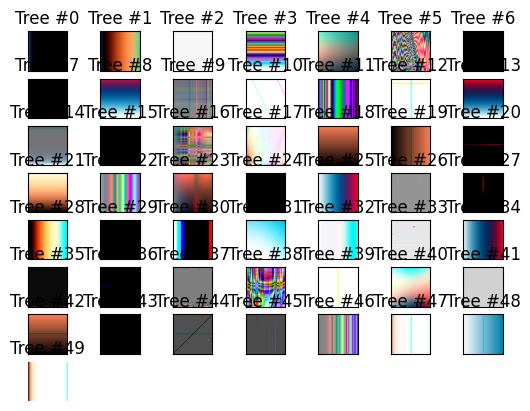

In [ ]:
#@title Preview population { run: "auto" }
new_population = False #@param {type:"boolean"}
image_size = 64 #@param {type:"slider", min:8, max:128, step:8}
figure_size = 6 #@param {type:"slider", min:2, max:16, step:2}
offset_x = 0.0 #@param {type:"number"}
offset_y = 0.0 #@param {type:"number"}
scale_x = 1.0 #@param {type:"number"}
scale_y = 1.0 #@param {type:"number"}
channel_mode = "divide" #@param ["identity", "divide", "multiply", "power"]

if new_population:
    gp.initialize_population()

nrows = int(np.sqrt(len(gp.population)))
ncols = int(len(gp.population) // nrows)
nrows += len(gp.population) - (nrows * ncols)
fig = plt.figure()

plt.rcParams['figure.figsize'] = [figure_size * nrows, figure_size * ncols]

for n in tnrange(len(gp.population), desc='Evaluating population...'):
    tree = gp.population[n]
    ax = fig.add_subplot(nrows, ncols, n + 1)

    img = gp.generate_image(tree=tree,
                            image_size=(image_size, image_size))
    at = th.nonzero(img, as_tuple=True)
    if len(at[0]) > 0:
        img[at] -= th.min(img[at])
    at = th.nonzero(img, as_tuple=True)
    if len(at[0]) > 0:
        img[at] /= th.max(img[at])
    ax.imshow(img, origin='lower', vmin=0., vmax=1., cmap='gray')
    ax.set_title(f'Tree #{n}')
    ax.set_xlim(0, image_size)
    ax.set_ylim(0, image_size)
    ax.set_xticks([])
    ax.set_yticks([])
plt.axis('off')
plt.show()


In [ ]:
#@title Save hi-res images
image_resolution_x = 2048 #@param {type:"slider", min:256, max:2048, step:128}
image_resolution_y = 2048 #@param {type:"slider", min:256, max:2048, step:128}
image_size_x = 9 #@param {type:"slider", min:5, max:40, step:1}
image_size_y = 16 #@param {type:"slider", min:5, max:40, step:1}

#@markdown Enter the tree numbers (separated by a comma):
tree_numbers = "0,24" #@param {type:"string"}
tree_numbers = [int(x) for x in tree_numbers.split(',')]

#@markdown Enter the pictures prefix:
picture_prefix = "gp_test" #@param {type:"string"}

when = f'{datetime.now():%Y%m%d%H%M%S%z}'

for x in tree_numbers:
    assert(x < len(gp.population)), f'Invalid tree number: {x} (can only evaluate up to {len(gp.population)} trees!)'

plt.rcParams['figure.figsize'] = [image_size_x, image_size_y]

for i in tnrange(len(tree_numbers), desc='Generating high-res images...'):
    n = tree_numbers[i]
    tree = gp.population[n]
    fname = f'{picture_prefix}_{when}_{str(n).zfill(3)}.png'
    img = gp.generate_image(tree=tree,
                            image_size=(image_resolution_y, image_resolution_x))
    at = th.nonzero(img, as_tuple=True)
    img[at] -= th.min(img[at])
    at = th.nonzero(img, as_tuple=True)
    if len(at[0]) > 0:
        img[at] /= th.max(img[at])
    plt.imshow(img, origin='lower', vmin=0., vmax=1., cmap='gray')
    plt.xlim(0, image_resolution_x)
    plt.ylim(0, image_resolution_y)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.draw()
    plt.savefig(fname=fname, transparent=True, format='png')
    # plt.show()

    files.download(fname)
plt.close()


Generating high-res images...:   0%|          | 0/2 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>